<a href="https://colab.research.google.com/github/AntoniousShehata/MachineLearning/blob/main/project_flight_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset about "Pricing airline tickets"

## The link of the Colab file:

##### https://colab.research.google.com/drive/1tCksxohN7LUpXLnBVw_FtgweQ9poY5HZ#scrollTo=8iogz4Qh2GBm

## Data Description:
##### Our database contains a comprehensive set of information regarding the departure and return destinations for flights operated by various airlines. Key data points include the number of transits, departure and arrival times, and the duration between them. At the forefront of the important information is the price for each flight.

## Importance of Flight Pricing:
##### Pricing airline tickets is crucial to align with market demands, profitability, and passengers' ability to afford the tickets.

## Data Analysis and Learning:
##### We will analyze and process this data to learn in a manner that suits the nature of the inputs and the desired outcomes.

## Benefits of Data Processing and Learning:
##### Processing the data and learning from it will provide pricing officials with a comprehensive view and insights through various charts. These visual aids will show how current prices compare to the optimal price for each flight, considering the duration and the time of day.

## The procedures of getting the dataset needed from Kaggle:
#### we will read the dataset directly from Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp -f kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list > /dev/null

In [ ]:
!kaggle datasets download -d viveksharmar/flight-price-data


Dataset URL: https://www.kaggle.com/datasets/viveksharmar/flight-price-data
License(s): MIT
flight-price-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -o flight-price-data.zip -d ./flight-price-data

Archive:  flight-price-data.zip
  inflating: ./flight-price-data/flight_dataset.csv  


## Installing and Importing Libraries

In [ ]:
!pip install feature_engine

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.metrics
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Reading the Dataset

In [ ]:
df = pd.read_csv("./flight-price-data/flight_dataset.csv")
df.

,Airline,Source,Destination,Total_Stops,Price,Date,Month,Year,Dep_hours,Dep_min,Arrival_hours,Arrival_min,Duration_hours,Duration_min
0,IndiGo,Banglore,New Delhi,0,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,2019,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,2019,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,2019,16,50,21,35,4,45


## Searching Dataset for nulls

In [ ]:
df.isnull().sum()

Airline           0
Source            0
Destination       0
Total_Stops       0
Price             0
Date              0
Month             0
Year              0
Dep_hours         0
Dep_min           0
Arrival_hours     0
Arrival_min       0
Duration_hours    0
Duration_min      0
dtype: int64

# Preprocessing Data

## Concatenation columns(Source and Destination) as (Form_To)
#### as to reduce number of columns we don not needed at our process

In [ ]:
df['From_To'] = df['Source'] + ' ' + df['Destination']

## Converting time to hours
#### as to let the duration a small values accurate and in one column

In [ ]:
def calculate_duration_in_hours(row):
    dep_total_hours = row['Dep_hours'] + row['Dep_min'] / 60
    arr_total_hours = row['Arrival_hours'] + row['Arrival_min'] / 60

    if arr_total_hours < dep_total_hours:
        arr_total_hours += 24

    duration_hours = arr_total_hours - dep_total_hours
    return duration_hours

## Converting time of the day to 4 zones of day
#### we will do this to let the time looks better for accuracy breformance as the tickets prices changes according to zones of the day not according just hour and second so data looks better now to learn

In [ ]:
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    elif 21 <= hour <= 23 or 0 <= hour < 5:
        return 'Night'
    else:
        return 'Invalid Hour'

### Applying the changes to the Dataset, drop unwanted columns, removing duplicates then displaying the Data

In [ ]:
df['Total_Duration_Hr'] = df.apply(calculate_duration_in_hours, axis=1)

df['Departure_Time'] = df['Dep_hours'].apply(categorize_hour)
df['Arrival_Time'] = df['Arrival_hours'].apply(categorize_hour)

df = df.drop(columns=['Year', 'Source', 'Destination', 'Dep_hours', 'Dep_min', 'Arrival_hours', 'Arrival_min', 'Duration_hours', 'Duration_min'])

df.drop_duplicates(inplace = True)

df.head()

,Airline,Total_Stops,Price,Date,Month,From_To,Total_Duration_Hr,Departure_Time,Arrival_Time
0,IndiGo,0,3897,24,3,Banglore New Delhi,2.833333,Night,Night
1,Air India,2,7662,1,5,Kolkata Banglore,7.416667,Morning,Afternoon
2,Jet Airways,2,13882,9,6,Delhi Cochin,19.000000,Morning,Night
3,IndiGo,1,6218,12,5,Kolkata Banglore,5.416667,Evening,Night
4,IndiGo,1,13302,1,3,Banglore New Delhi,4.750000,Afternoon,Night


### Graph presenting the time zones of the day

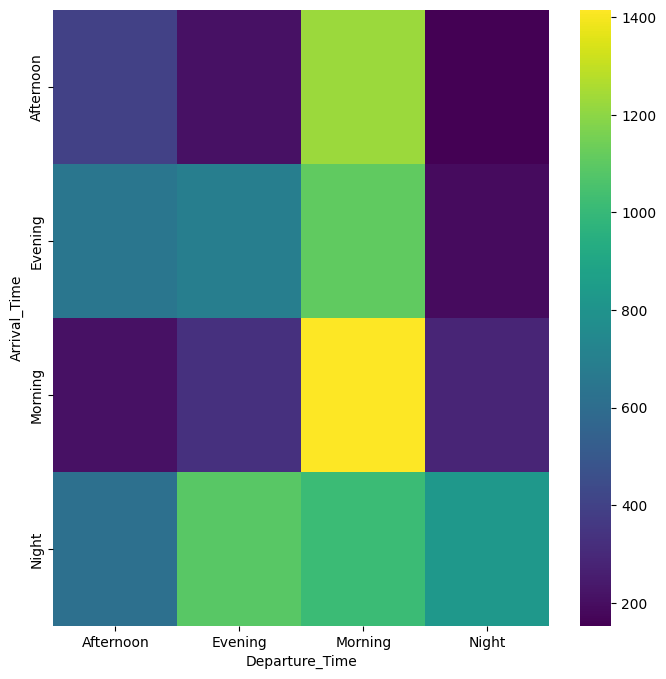

In [ ]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Arrival_Time'].value_counts()
    for x_label, grp in df.groupby('Departure_Time')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Departure_Time')
_ = plt.ylabel('Arrival_Time')

## Observe size of data at the main dataset, train, test


In [ ]:
df_train, df_test = train_test_split(df)
print("df_size:", df.shape)
print("df_train size:", df_train.shape)
print("df_test size:", df_test.shape)

df_size: (10394, 9)
df_train size: (7795, 9)
df_test size: (2599, 9)


## Observe type of each column

In [ ]:
df_train.dtypes

Airline               object
Total_Stops            int64
Price                  int64
Date                   int64
Month                  int64
From_To               object
Total_Duration_Hr    float64
Departure_Time        object
Arrival_Time          object
dtype: object

<Axes: >

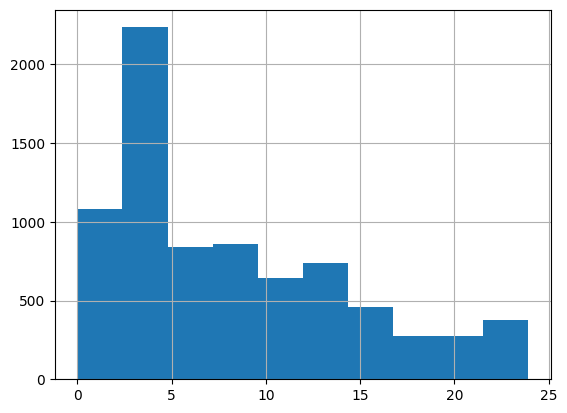

In [ ]:
df_train["Total_Duration_Hr"].hist()

<Axes: ylabel='Airline'>

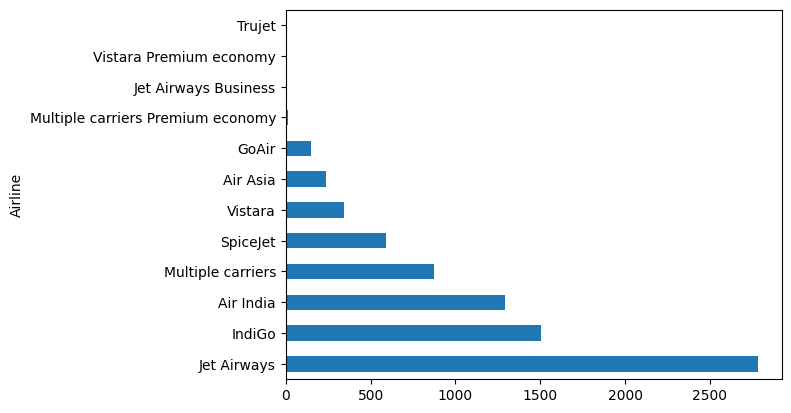

In [ ]:
df_train["Airline"].value_counts().plot(kind='barh')

## Split Test Train

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

x_train = df_train.drop("Price", axis=1)
y_train = df_train["Price"]
x_test = df_test.drop("Price", axis=1)
y_test = df_test["Price"]

## Transform the columns using ('StandardScaler' and 'OneHotEncoder')

In [ ]:
numerical_attributes = x_train.select_dtypes(include=["int64","float64"]).columns
categorical_attributes = x_train.select_dtypes(include=["object"]).columns
print("numerical attributes:", numerical_attributes)
print("Categorical attributes:", categorical_attributes)
ct= sklearn.compose.ColumnTransformer([
    ("standard_scaling", sklearn.preprocessing.StandardScaler(),numerical_attributes),
    ("one-hot_scaling", sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore"),categorical_attributes)
])
ct.fit(x_train)
x_train = ct.fit_transform(x_train)
x_test = ct.transform(x_test)

numerical attributes: Index(['Total_Stops', 'Date', 'Month', 'Total_Duration_Hr'], dtype='object')
Categorical attributes: Index(['Airline', 'From_To', 'Departure_Time', 'Arrival_Time'], dtype='object')


# Building Models (Linear & DecisionTree & Random Forest)

## Linear Regression model

In [ ]:
param_grid_model1 = {
    "fit_intercept": [True]
}

model1 = GridSearchCV(LinearRegression(), param_grid_model1, scoring="neg_mean_squared_error", cv=5, n_jobs=1)

model1.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=1,
             param_grid={'fit_intercept': [True]},
             scoring='neg_mean_squared_error')

## DecisionTree model

In [ ]:
param_grid_model2 = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 10, 20]
}

model2 = GridSearchCV(DecisionTreeRegressor(), param_grid_model2, scoring="neg_mean_squared_error", cv=5, n_jobs=1)

model2.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 10, 20]},
             scoring='neg_mean_squared_error')

## RandomForest model

In [ ]:
param_grid_model3 = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10],
    "min_samples_split": [2]
}

model3 = GridSearchCV(RandomForestRegressor(), param_grid_model3, scoring="neg_mean_squared_error", cv=5, n_jobs=1)

model3.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
             param_grid={'max_depth': [None, 10], 'min_samples_split': [2],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

## Retrieve the best models and their scores then convert it to +MSE(Mean Squared Error)
##### Here, model1, model2, and model3 are presumably models that have been trained and evaluated. Each has a method best_estimator_.
##### which returns the best model found during the training process.

### The negative sign here (-model.best_score_)
##### is because of scikit-learn framework, the convention is to maximize a score (such as R^2 for regression) rather than minimize an error (such as MSE). So, we convert it to MSE for consistency in understanding.
##  --------------------------------------------------------------
###  Lower MSE indicates better performance:
#### meaning the model's predictions are closer to the actual values on average.

In [ ]:
best_score_model1 = model1.best_estimator_
best_score_model2 = model2.best_estimator_
best_score_model3 = model3.best_estimator_

best_score_model1 = -model1.best_score_
best_score_model2 = -model2.best_score_
best_score_model3 = -model3.best_score_

print("Linear Regression Best MSE:", best_score_model1)
print("Decision Tree Best MSE:", best_score_model2)
print("Random Forest Best MSE:", best_score_model3)

models_scores = {
    "Linear Regression": best_score_model1,
    "Decision Tree": best_score_model2,
    "Random Forest": best_score_model3
}

best_model_name = min(models_scores, key=models_scores.get)
best_model_score = models_scores[best_model_name]

print(f"The best model is {best_model_name} with an MSE of {best_model_score}.")

Linear Regression Best MSE: 7711063.626698606
Decision Tree Best MSE: 4954973.161556109
Random Forest Best MSE: 4317169.557661513
The best model is Random Forest with an MSE of 4317169.557661513.


### Support Vector Machine (SVM)
#### Purpose:
##### SVMs are primarily used for classification tasks, where the goal is to categorize input data into one of two or more classes, based on past observations (training data) where the correct classification is known.

In [ ]:
print("Best found hyperparameters of SVM classifier = {}".format(model1.best_params_))
print("Best found hyperparameters of SVM classifier = {}".format(model2.best_params_))
print("Best found hyperparameters of SVM classifier = {}".format(model3.best_params_))

Best found hyperparameters of SVM classifier = {'fit_intercept': True}
Best found hyperparameters of SVM classifier = {'max_depth': 20, 'min_samples_split': 20}
Best found hyperparameters of SVM classifier = {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


### Retrieve the best Random Forest model
##### Make predictions on the test data
##### Calculate (MSE) on test data


In [ ]:
best_model3 = model3.best_estimator_

y_pred = best_model3.predict(x_test)

mse_test = mean_squared_error(y_test, y_pred)

print("Random Forest Test MSE:",mse_test)

Random Forest Test MSE: 4657123.287287756


### Calculate evaluation metrics

In [ ]:
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Test MSE: {mse_test}")
print(f"Random Forest Test RMSE: {rmse_test}")
print(f"Random Forest Test MAE: {mae_test}")
print(f"Random Forest R-squared: {r2}")

Random Forest Test MSE: 4657123.287287756
Random Forest Test RMSE: 2158.0369059142054
Random Forest Test MAE: 1343.1657129506661
Random Forest R-squared: 0.8022130756107786


#### Graph present Random Forest Model Performance Metrics

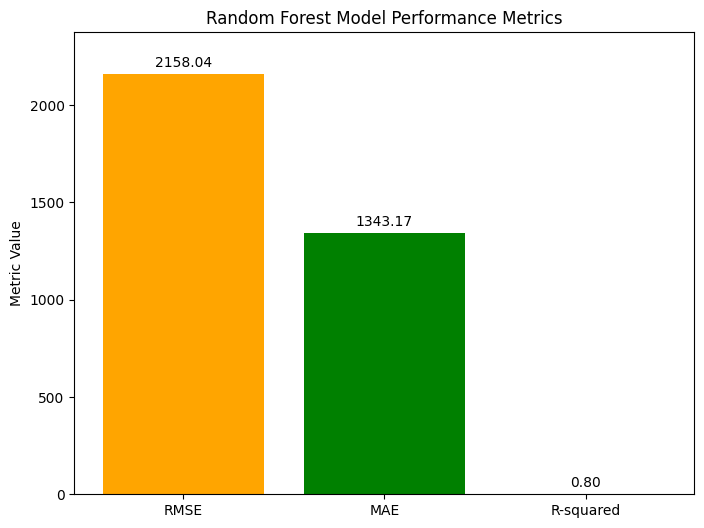

In [ ]:
metrics = ['RMSE', 'MAE', 'R-squared']
values = [rmse_test, mae_test, r2]

plt.figure(figsize=(8, 6))

bars = plt.bar(metrics, values, color=['orange', 'green', 'red'])

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.title('Random Forest Model Performance Metrics')
plt.ylabel('Metric Value')

plt.ylim(0, max(values) + max(values) * 0.1)

plt.show()

#### Visualization: Actual vs Predicted scatter plot

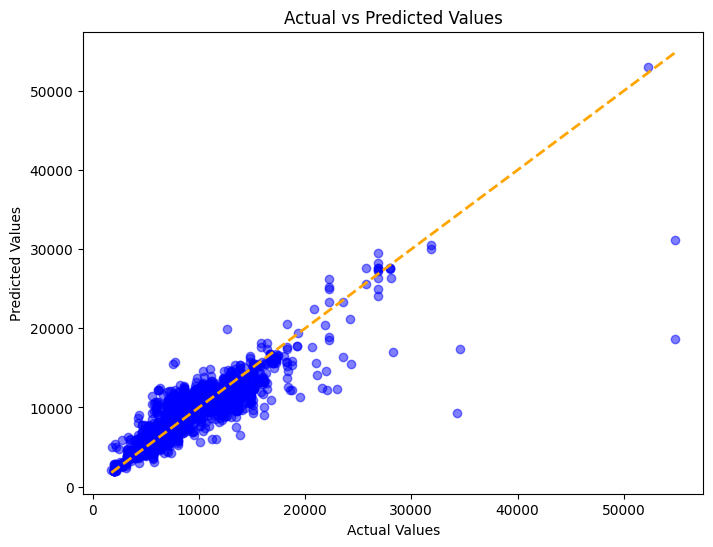

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='orange', linewidth=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

#### Visualization: Residual plot

Horizontal Line (orange line): Represents the zero residual line. Points on this line indicate that the model's predictions are exactly on point.

Scatter of Points: Each point represents a data point in your dataset. The x-axis shows the predicted values from the model, and the y-axis shows the residuals (difference between actual and predicted values).

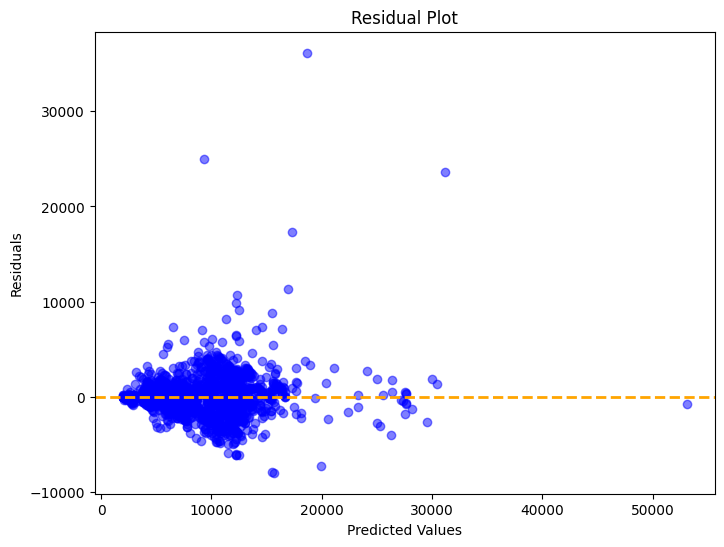

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='orange', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Conclusion

### Why We Prefer the Random Forest Regressor:
#### from all models the Random Forest stands out as a strong performer in our dataset. It consistently demonstrates good performance.

### Overfitting Concerns:
#### Random Forest is siutable but sometimes fit too much so We must strike a balance to ensure that it generalizes well to data.

### why not Linear Regression:
#### A simpler model but it tends to capture less variability. Here, it struggles to fully account for the variance in the data.

### The Challenges:
### Two problems affect performance:

#### Skewed Price Variable: prices is not balanced that can impact predictions.
#### Departure and Arrival Times: Inconsistent introduce noise and affect accuracy.

### Recommendation:

#### Address Skewness: We should handel the skewed price variable to improve overall accuracy.
#### Ensure Time Accuracy: handling departure and arrival times will give us reliable predictions.